In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements

In [3]:
# Hooks again but quite different to the previous ones.
# 19 regions each which must add up to 15
# the 2x2 will come into play for the square regions at the bottom
# guess we iterate through the hooks and test if 15 can be made from 
# each potential placement within each region

url='https://www.janestreet.com/puzzles/hooks-7/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:11]))

The grid below can be partitioned into 9 L-shaped “hooks”. The largest is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains 15 squares), and so on. The smallest hook is just a single square. Find where the hooks are located, and place nine 9’s in the largest hook, eight 8’s in the next-largest, etc., down to one 1 in the smallest hook. The filled squares must form a connected region. (Squares are “connected” if they are orthogonally adjacent.) Furthermore, every 2-by-2 region must contain at least one unfilled square. The sum of the values in each of the connected shaded regions must be the same. The answer to this puzzle is the product of the areas of the connected groups of empty squares in the completed grid.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2021/02/20210202_hooks_7.png" width="500" height="300">

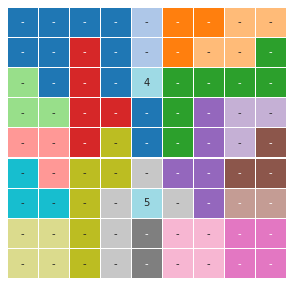

In [11]:
#Setup the constraints
# use 20 for the filled cells and treat as smaller 
# hooks with a different total

groups = np.array([[0 ,0 ,0 ,0 ,1 ,2 ,2 ,3 ,3 ],
                   [0 ,0 ,6 ,0 ,1 ,2 ,3 ,3 ,4 ],
                   [5 ,0 ,6 ,0 ,20 ,4 ,4 ,4 ,4 ],
                   [5 ,5 ,6 ,6 ,0 ,4 ,8 ,9 ,9 ],
                   [7 ,7 ,6 ,16,0 ,4 ,8 ,9 ,10],
                   [18,7 ,16,16,15,8 ,8 ,10,10],
                   [18,18,16,15,20,15,8 ,11,11],
                   [17,17,16,15,14,13,13,12,12],
                   [17,17,16,15,14,13,13,12,12]                   
                 ])

fixed = np.array([[0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,4,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,5,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0]
                 ])

def grid_print(groups,numbers):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=0.25)
    ax.axis("off")
    
grid_print(groups,fixed)

# use -1 to denote unfilled
fixed[fixed==0] =-1

In [137]:
class Matrix():
    def __init__(self,groups):
        self.groups = groups
        self.potential_grids = [[-9,np.ones((9,9),dtype=int)*-1,[0,0,9,9]]] # list of all grids not yet ruled out.[Level,grid,coordinates of the grid yet to be filled]
        self.solution = []
        self.totals =[11,15,15,15,15,15,15,15,15,15,15,15,15,15,15,10,15,15,15]
        self.splits ={}
        for i in range(19):
            length = np.sum(groups==i)
            self.splits[i] =  [list(i) for i in itertools.product([0, 1], repeat=length)]
     
    #########################################################
    # Code to get the initial valid grids 

    def add_layer(self,grid,coords,lvl,alignment):
        row_start,col_start,row_end, col_end = coords
    
        if alignment == 0:
            grid[row_start:row_end,col_start] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_start +=1
    
        if alignment == 1:
            grid[row_start:row_end,col_start] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_start +=1 

        if alignment == 2:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_start,col_start:col_end] =lvl
            row_start +=1
            col_end -=1
        
        if alignment == 3:
            grid[row_start:row_end,col_end-1] =lvl
            grid[row_end-1,col_start:col_end] =lvl
            row_end -=1
            col_end -=1 
    
        coords = [row_start,col_start,row_end, col_end]
        
        return grid,coords
    
    def check_grid(self,grid):
        isValid = 1
        #check the 2 fixed numbers
        if (grid[2,4] !=-1) & (grid[2,4] !=4):
            return False
        if (grid[6,4] != -1) &(grid[6,4] != 5):
            return False
        
        for i in range(19):
            group = grid[groups==i]
            if -1 not in group:
                isValid *= self.check_group(group,self.totals[i],self.splits[i])

        return isValid
                    
    def check_group(self,group,param,splits):
        for split in splits:
            test = group * split
            if self.valid_group(test,param):
                    return 1
        return 0
    

    def valid_group(self,pos,param):
        if np.sum(pos) !=param:
                return False
        return True
    
    #########################################################
    # Code to get the cells forced by the group params
    # loop through all the splits for each group
    # common to all the splits
    # compare the 2 different forced matricies, if there are inconsistencies 
    # first value returned is zero and it's flagged as inconsistent
    
    def forced_cells(self,hook):
        forced = np.ones((9,9),dtype=int)*-1
        forced[2,4] == 1
        forced[6,4] == 1        
        # loop through the params to determine forced cells
        for i in range(19):
            forced[self.groups==i] = self.forced_group(hook[self.groups==i],self.totals[i],self.splits[i])
       
        
        # set the cell with 1 in as 1 then loop through and fill in cells neeeded to ensure connectivity 
        forced[hook==1] =1
        changes =1
        while changes >0:

            changes = 0
            for i,j in itertools.product(range(9),range(9)):
                if forced[i,j] == -1:
                    test =forced*hook
                    test[i,j] = 0
                    if np.max(label(test!=0,connectivity=1)) > 1:
                    #if placing zero would break connectivity set 1
                        forced[i,j]=1
                        changes =1
        
        test =forced*hook
        # check that the forced cells do not violate the count
        for i in range(1,10):
            if np.sum(test==i) > i:
                return 0,forced
            
        # check that the forced cells do not violate 2x2
        if self.twobytwo(test):
            return 0,forced
        
        return  1,forced
    

    
      
    def forced_group(self,group,param,splits):
        poss_group =[]
        length = len(splits[0])
        for split in splits:
            test = group * split
            if self.valid_group(test,param):
                    poss_group.append(split)
        poss_array = np.array(poss_group)
        forced = np.ones(length,dtype=int)*-1
        for i in range(length):
            if np.all(poss_array[:,i]==1):
                forced[i] =1
            elif np.all(poss_array[:,i]==0):
                forced[i] =0
        return forced
    
    def twobytwo(self,grid):
        for i,j in itertools.product(range(9),range(9)):
            if (i > 0 and j > 0 and 
                grid[i,j] > 0 and
                grid[i-1,j-1] > 0 and 
                grid[i-1,j] > 0 and 
                grid[i,j-1] > 0):
                    return True
    
            if (i > 0 and j < 6 and
                grid[i,j] > 0 and
                grid[i-1,j+1] > 0 and 
                grid[i-1,j] > 0 and 
                grid[i,j+1] > 0):
                    return True
    
            if (i < 6 and j > 0 and
                grid[i,j] > 0 and
                grid[i+1,j-1] > 0 and 
                grid[i+1,j] > 0 and 
                grid[i,j-1] > 0):
                    return True

    
            if (i < 6 and j < 6 and
                grid[i,j] > 0 and
                grid[i+1,j+1] > 0 and 
                grid[i+1,j] > 0 and 
                grid[i,j+1] > 0):
                    return True
    
        return False
    
########################################################
    # Fill the final cells by backtracking
        
        
    def fill_rest(self,grid,hooks):
        for row,col in itertools.product(range(9),range(9)):
            if grid[row,col]==-1:
                for digit in range(2):
                    if self.possible(digit,row,col,grid,hooks):
                        grid[row,col] = digit
                        self.fill_rest(grid,hooks)
                        grid[row,col] = -1
                return
        sol_print(grid,hooks)
        print("The product of the areas is : {:,.0f}".format(self.areas(grid)))
        sums = np.zeros(19)
        #for i in range(19):
        #    sums[i] = np.sum((grid*hooks)[self.groups==i])
        #print(sums)
                                
                            
    def possible(self,digit,row,col,grid,hooks):
        test = grid*hooks
        test[row,col] = hooks[row,col]*digit

    
    #check the placement doesn't break connectivity
        if np.max(label(test!=0,connectivity=1)) > 1:
            return False
        
    #check the placement doesn't break 2 by 2
        if self.twobytwo(test):
            return False
    
     #check the placement doesn't exceed the permitted count of that number
        for num in range(2,10):
            if np.sum(test == num) > num:
                   return False
                
        #check groups
        for i in range(19):
            group = test[groups==i]
            if np.all(group > -1):
                if not self.valid_group(group,self.totals[i]):
                    return False
      
        return True
        
    ##############################################
    # Get the products of the areas of the connected cells
    
    def areas(self,grid):
        labels, num = measurements.label(np.logical_not(grid!=0))
        areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))
        return np.prod(areas)
    
    
    
    ###############################################
    # Main solver.
    
    def solve(self):  
        while len(self.potential_grids) > 0:
            temp_grid = self.potential_grids.pop(0)
            #create the potential rotations at the given level
            rotations = []
        
            for alignment in range(4):
                lvl,grid,coords = dcopy(temp_grid)
                grid,coords = self.add_layer(grid,coords,-lvl,alignment)
                if lvl != -1 :
                    rotations.append([lvl+1,grid,coords])
                else:
                     rotations = [[lvl+1,grid,coords]]
    
            #check valid grids (where the sum can be made from available digits) and save the ones that work
            for i in range(len(rotations)):
                lvl,g,coords = rotations[i]
                if self.check_grid(g):
                    if lvl !=0:    
                        self.potential_grids.append([lvl,g,coords])
                    else:
                        self.solution.append(g)
                       
                      
        print("There are {} valid hook placements\n".format(len(self.solution)))


        #solve each grid in the cut down list
        forced_grids = []
        for i in range(len(self.solution)):
            #print("Checking: ",i+1)
            hooks = self.solution[i]
            
            flag,forced_grid = self.forced_cells(hooks)
            if flag:
                #for valid forced grids solve the final matrix
                #print("still to solve",np.sum(forced_grid==-1))
                self.fill_rest(forced_grid,hooks)
            #else:
                #print("***INCONSISTENT***")
                

                
#########################
# Code to print in a "nice" format
                            
def sol_print(solved,matrix):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(matrix,annot=x,cbar=False,cmap="Set3_r",fmt="",linewidths=0.25)
    ax.axis("off")
    

There are 172 valid hook placements

The product of the areas is : 2,200

 Solution took 602.0880 seconds



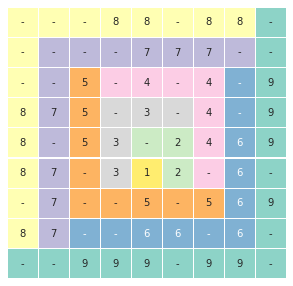

In [138]:
start = time.perf_counter()
test = Matrix(groups)
test.solve()
stop =  time.perf_counter()
print('\n Solution took {:0.4f} seconds\n'.format((stop-start)))

In [139]:
url='https://www.janestreet.com/puzzles/solutions/february-2021-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:9]))

### Puzzle solution
<img src="" width="3" height="4">